In [4]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import supervision as sv
import torch
import pandas as pd
import time
import os
from scipy.spatial import distance

%matplotlib inline

In [5]:
#frames per second function
def get_fps(frame_number):
    if frame_number == 0:
        get_fps.start_time = time.time()
        return 0.0
    end_time = time.time()
    fps = float(frame_number) / float(end_time - get_fps.start_time)
    return fps


### Distance functions

In [2]:
def distance(point, rectangle):
    image = np.zeros((100, 100), dtype='uint8')
    (x0, y0) = point
    (x1,y1) = rectangle[:2]
    (x2,y2) = rectangle[2:]
    
    #minimum distance is in some corner point
    if x0>=x2 and y0<=y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<=x1 and y0<=y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<=x1 and y0>=y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>=x2 and y0>=y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]   
    # point is inside rectangle  - distance is the distance between two centers  
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        print(d_coord)     
        
    #draw distance
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(255,0,0), thickness=1)
    cv2.circle(image, (x0,y0), radius=0, color=(255, 0, 0), thickness=-1)
    cv2.line(image, d_coord[:2], d_coord[2:], color = (255, 255, 255), thickness=1)
    plt.imshow(image)
    plt.axis("off")
    return d

In [2]:
def get_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = rect2[:2]
    (x2,y2) = rect2[2:]
    
    #d=0
    
    #minimum distance is in some corner point
    if x0>x2 and y0<y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<x1 and y0<y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<x1 and y0>y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>x2 and y0>y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]      
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        
    
    return d, d_coord

In [16]:
def get_circular_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = int((rect2[0]+rect2[2])/2), int((rect2[1]+rect2[3])/2)
    
    d=np.sqrt((x1-x0)**2+(y1-y0)**2)
    d_coord = [x0,y0, x1,y1]
    
    
    return d, d_coord

In [6]:
def intersection_distance(rect1, rect2):
    (x11, y11, x12, y12) = rect1
    (x21, y21, x22, y22) = rect2
    
    #coordinates of intersection
    if x12<x21 or x11>x22 or y12<y21 or y11>y22:
        intersect = 0.0
    else:
        #find coordinates of intersection
        x1 = max(x11, x21)
        y1 = max(y11, y21)
        x2 = min(x12, x22)
        y2 = min(y12, y22)
        
                
        intersect = float((x2-x1)*(y2-y1))
        
    return intersect    
        

In [7]:
def side_distance(rect1, rect2):
    
    (x11, y11, x12, y12) = rect1
    (x21, y21, x22, y22) = rect2
    #get width and height of the second rect
    width2 = x22-x21
    height2 = y22-y21  
             
    
    if y21>=y11-height2 and y21<=y12: #horizontal area
        d = min([np.abs(x11-x21),
               np.abs(x11-x22),
               np.abs(x12-x21),
               np.abs(x12-x22)])
        
    elif x21>=x11-width2 and x21<=x12: #vertical area
        d = min([np.abs(y11-y21),
               np.abs(y11-y22),
               np.abs(y12-y21),
               np.abs(y12-y22)]) 
        
    elif x21>=x12 and y22<=y11: #upper right area
        d = np.sqrt((x21-x12)**2+(y22-y11)**2)
                
    elif x22<=x11 and y22<=y11: #upper left area
        d = np.sqrt((x22-x11)**2+(y22-y11)**2)
        
        
    elif x22<=x11 and y21>=y12: #bottom left area
        d = np.sqrt((x22-x11)**2+(y21-y12)**2)
        
        
    elif x21>=x12 and y21>=y12: #bottom right area
        d = np.sqrt((x21-x12)**2+(y21-y12)**2) 
        
        
    
    return d

In [ ]:
intersection_distance([1,10,10,20], [1,10,5,15])

20.0

5


10.198039027185569

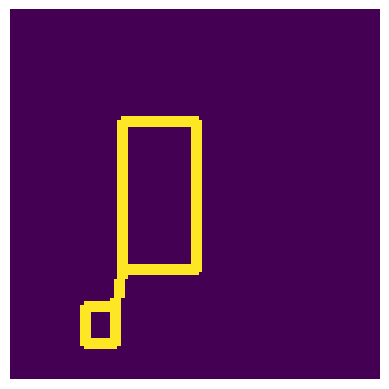

In [53]:
side_distance([30,30,50,70], [20,80,28,90])

### Create images from video

In [4]:
def frames_from_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    name = video_path.split("/")[-1].split(".")[0]
        
    count=0
            
    while cap.isOpened():
        
        success, frame = cap.read()
                 
              
        cv2.imwrite(f"{output_path}/{name}_frame{count}.jpg", frame)  
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit
            break
        count += 1
        if (count > (video_length)-1):
            
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)

### Collected frames from videos

In [7]:
frames_from_video("videos/industry3.mp4", "frames")

Done extracting frames.
432 frames extracted


In [5]:
frames_from_video("videos/industry2.mp4", "frames")

Done extracting frames.
471 frames extracted


### Val frames

In [12]:
frames_from_video("videos/industry1.mp4", "frames")

Done extracting frames.
340 frames extracted


In [13]:
frames_from_video("videos/industry5.mp4", "frames")

Done extracting frames.
469 frames extracted


In [18]:
frames_from_video("videos/industry7.mp4", "frames")

Done extracting frames.
509 frames extracted


In [19]:
frames_from_video("videos/industry8.mp4", "frames")

Done extracting frames.
697 frames extracted


In [20]:
frames_from_video("videos/industry4.mp4", "frames")

Done extracting frames.
398 frames extracted


In [15]:
frames_from_video("videos/industry5.mp4", "frames")

Done extracting frames.
469 frames extracted


In [21]:
frames_from_video("videos/industry9.mp4", "frames")

Done extracting frames.
656 frames extracted


In [15]:
frames_from_video("videos/industry10.mp4", "frames")

Done extracting frames.
480 frames extracted


In [43]:
frames_from_video("videos/industry14.mp4", "frames")

Done extracting frames.
403 frames extracted


In [5]:
frames_from_video("videos/industry15.mp4", "frames")

Done extracting frames.
462 frames extracted


In [6]:
frames_from_video("videos/industry16.mp4", "frames")

Done extracting frames.
669 frames extracted


In [7]:
frames_from_video("videos/industry17.mp4", "frames")

Done extracting frames.
1032 frames extracted


### Train YOLOv8 on machinery dataset

In [8]:
#Load a model
model = YOLO("yolov8n.pt")  # take pretrained model



# Use the model
model.train(data="data.yaml", epochs=50, imgsz=640, batch=16, pretrained=True, mosaic=0.0)  # train the model

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018A6FEB5E20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [13]:
results = pd.read_csv("runs/detect/train5/results.csv")

In [14]:
results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.00910,2.02750,1.14550,1.00000,0.08572,0.58689,0.22034,1.0981,2.98320,1.2235,0.000543,0.000543,0.000543
1,2,0.81979,1.26120,1.00660,0.21091,0.13028,0.51706,0.31738,1.4095,2.71990,1.4729,0.001077,0.001077,0.001077
2,3,0.83122,1.06800,1.03240,0.67723,0.58418,0.65053,0.36270,1.7486,1.63550,1.5490,0.001589,0.001589,0.001589
3,4,0.85125,0.96312,1.04360,0.29616,0.40695,0.25574,0.09485,2.2742,3.12020,2.0637,0.001568,0.001568,0.001568
4,5,0.76972,0.77899,0.98678,0.55824,0.62059,0.68635,0.26947,2.0072,2.31140,1.6716,0.001568,0.001568,0.001568
5,6,0.72944,0.67239,0.96332,0.61016,0.76748,0.80091,0.36373,1.9702,1.49120,1.8246,0.001535,0.001535,0.001535
6,7,0.73622,0.61149,0.96470,0.65776,0.63531,0.65406,0.28787,1.9769,1.39790,2.1093,0.001502,0.001502,0.001502
7,8,0.72266,0.59011,0.96078,0.80331,0.85123,0.82713,0.48420,1.3909,1.05150,1.4609,0.001469,0.001469,0.001469
8,9,0.70066,0.55588,0.94890,0.60679,0.67958,0.66047,0.25020,2.0394,1.47670,1.7823,0.001436,0.001436,0.001436
9,10,0.67982,0.52147,0.94238,0.60083,0.73713,0.75574,0.41972,1.5371,1.29800,1.4306,0.001403,0.001403,0.001403


In [15]:
stripped_columns = [column.strip() for column in results.columns]
results.columns = stripped_columns

In [16]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

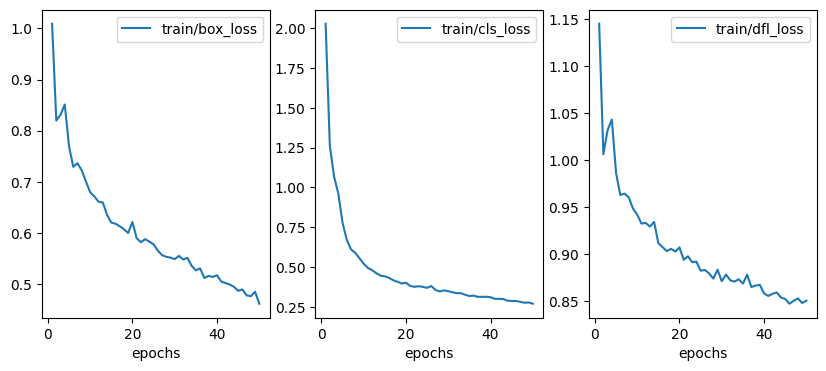

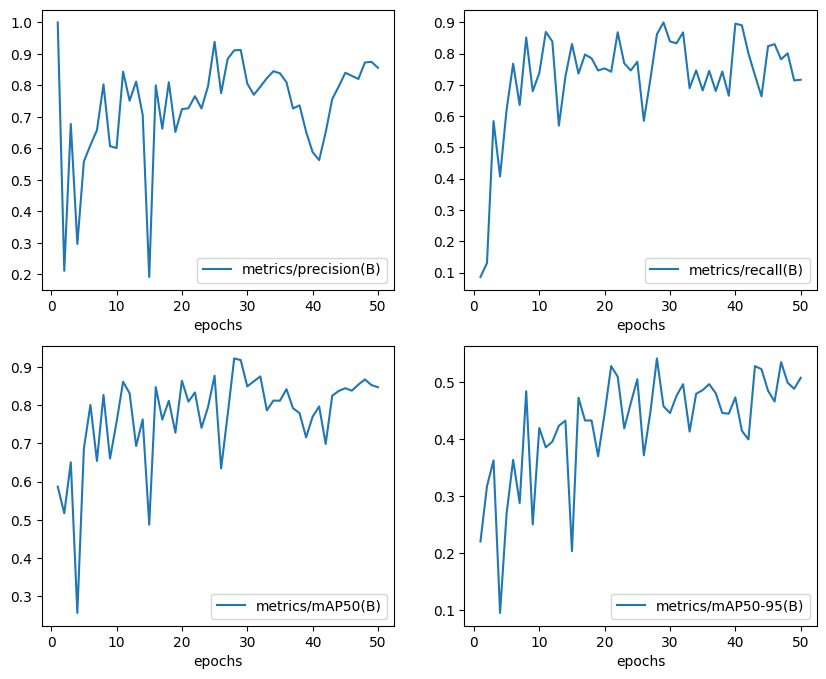

In [17]:
columns = ['train/box_loss','train/cls_loss', 'train/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)',
           'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
for i, column in enumerate(columns[:3]):
    axes[i].plot(results['epoch'], results[column], label=column)
    axes[i].set_xlabel("epochs")
    axes[i].legend(loc="upper right")   
plt.tight_layout
plt.savefig('figures/losses.png')
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i, column in enumerate(columns[3:]):
    axes[i//2, i%2].plot(results['epoch'], results[column], label=column)
    axes[i//2, i%2].set_xlabel("epochs")
    axes[i//2, i%2].legend(loc="lower right")   
plt.tight_layout
plt.savefig('figures/metrics.png')
plt.show()

  

### Validation of the trained model

In [92]:
model = YOLO('runs/detect/train5/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(data="data.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]
                   all        101        293      0.911      0.861      0.923      0.541
             machinery        101        101      0.875      0.723      0.891       0.43
                person        101        192      0.947          1      0.955      0.652
Speed: 0.5ms preprocess, 55.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val8


In [31]:
!yolo task=detect mode=val model="runs/detect/train/weights/best.pt" data="data.yaml" conf=0.25 source="data/test/images"

Ultralytics YOLOv8.0.199  Python-3.11.6 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs

val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:09<00:56,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:19<00:48,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [0

In [5]:
model.predict("videos/test_video/industry2.mp4", save=True, imgsz=640, conf=0.25)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 138.8ms
video 1/1 (2/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 63.5ms
video 1/1 (3/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 47.2ms
video 1/1 (4/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery,

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'machinery', 1: 'person'}
 orig_img: array([[[174, 175, 170],
         [115, 116, 111],
         [194, 195, 190],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        [[204, 205, 200],
         [188, 189, 184],
         [ 75,  76,  71],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        [[193, 194, 189],
         [242, 243, 238],
         [203, 204, 199],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        ...,
 
        [[ 99, 116, 120],
         [100, 117, 121],
         [104, 121, 125],
         ...,
         [ 46,  47,  34],
         [ 45,  46,  33],
         [ 45,  46,  33]],
 
        [[102, 119, 123],
         [104, 121, 125],
         [107, 124, 128],
         ...,
         [ 46

### Tracking with bytetrack

In [8]:
model = YOLO('runs/detect/train5/weights/best.pt')
byte_tracker = sv.ByteTrack()

In [13]:
cap = cv2.VideoCapture("videos/industry1.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


cap_writer = cv2.VideoWriter('result_industry1.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))

success, frame = cap.read()
frame_num=0
total_fps = 0

while success:
    
    
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)          
    detections = byte_tracker.update_with_detections(detections)
    bboxes = detections.xyxy
    confidences = detections.confidence
    class_ids = detections.class_id
    results = []
    machinery_boxes = []
    people_boxes = []
    for bbox, confidence, class_id in zip(bboxes, confidences, class_ids):
        # results.append({
        # "bbox": bbox.numpy().astype("int"),
        # "confidence": confidence,
        # "class_id": class_id
        # })
        if class_id == 0: #machinery
            machinery_boxes.append(
            bbox.astype("int")
            )
        elif class_id == 1: #person
            people_boxes.append(
            bbox.astype("int")
            )               
                           
        # print(machinery_boxes)
        bbox = bbox.astype("int")
        cv2.rectangle(frame, bbox[:2], bbox[2:], color = (255,0,0), thickness=2)
        cv2.rectangle(frame, (frame_width-100, 20), (frame_width-10, 60), (0,0,0), -1)
        fps = get_fps(frame_num)
        cv2.putText(frame, "%.2f FPS" % fps, (frame_width-100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX , fontScale = 0.5, color=(255, 255, 255), thickness=1)
    
    total_fps+=fps 
                
    # print(cars_boxes)            
    # d = get_distance(cars_boxes[0], cars_boxes[1])
    # print(d)
                
    for person in people_boxes:
        for machine in machinery_boxes:
            intersection_d = intersection_distance(machine, person)
            side_d = side_distance(machine, person)
            if side_d < 20 or intersection_d > 0:
                cv2.rectangle(frame, person[:2], person[2:], color = (0, 0, 255), thickness=2) 
                cv2.rectangle(frame, machine[:2], machine[2:], color = (0, 0, 255), thickness=2)
                cv2.putText(frame, "ALARM!", (20, 50), cv2.FONT_HERSHEY_SIMPLEX , fontScale = 1, color=(0, 0, 255), thickness=5) 
                            
    imS = cv2.resize(frame, (960, 540))  
    cap_writer.write(frame)      
    cv2.imshow('YOLO V8 Detection', imS)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    success, frame = cap.read()
    frame_num+=1
    

cap.release()

cv2.destroyAllWindows()

0: 384x640 2 persons, 71.6ms
Speed: 2.0ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 80.1ms
Speed: 1.0ms preprocess, 80.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 66.0ms
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 65.7ms
Speed: 1.0ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 68.8ms
Speed: 2.0ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 73.6ms
Speed: 1.0ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per imag

In [14]:
total_fps/(frame_num+1)

11.779907633434403

### Convert model to ONNX

In [3]:
model = YOLO('runs/detect/train5/weights/best.pt')
model.export(format="onnx",imgsz=[640,640], opset=12)

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train3\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (34.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ---------------------------------------- 13.3/13.3 MB 17.7 MB/s eta 0:00:00

requirements: AutoUpdate success  15.0s, installed 1 package: ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.1 opset 12...
ONNX: export success  16.6s, saved as 'runs\detect\train3\weights\best.onnx' (11.7 MB)

Export complete (18.5s)
Results saved to C:\Projects\Distance_project\runs\detect\train3\weights
Predict:         yolo predict task=detect model=runs\detect\train3\weights\best.onnx imgsz=640  
Validate:      

'runs\\detect\\train3\\weights\\best.onnx'

In [8]:
model.predict("test_frames/test.jpg", save=True)


image 1/1 c:\Projects\Distance_project\test_frames\test.jpg: 416x640 1 machinery, 2 persons, 180.0ms
Speed: 0.0ms preprocess, 180.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict6


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'machinery', 1: 'person'}
 orig_img: array([[[ 24,  20,  15],
         [ 25,  21,  16],
         [ 25,  21,  16],
         ...,
         [ 35,  33,  25],
         [ 34,  32,  24],
         [ 33,  31,  23]],
 
        [[ 22,  18,  13],
         [ 24,  20,  15],
         [ 25,  21,  16],
         ...,
         [ 31,  29,  21],
         [ 30,  28,  20],
         [ 29,  27,  19]],
 
        [[ 25,  21,  16],
         [ 25,  21,  16],
         [ 26,  22,  17],
         ...,
         [ 28,  26,  18],
         [ 27,  25,  17],
         [ 27,  25,  17]],
 
        ...,
 
        [[164, 162, 162],
         [165, 163, 163],
         [166, 164, 164],
         ...,
         [ 35,  40,  41],
         [ 35,  40,  41],
         [ 34,  39,  40]],
 
        [[165, 163, 162],
         [165, 163, 162],
         [166, 164, 164],
         ...,
         [ 35

: 

### Using segmentation

#### Compute the distance between the masks

In [127]:
image = np.array([[0,0,0,0,0,0],
         [1,1,1,0,0,0],
         [1,1,0,0,0,0],
         [1,0,0,0,0,2],
         [0,0,0,2,2,2],
         [0,0,0,0,2,2]],dtype=np.uint8)

In [128]:
image

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 2],
       [0, 0, 0, 2, 2, 2],
       [0, 0, 0, 0, 2, 2]], dtype=uint8)

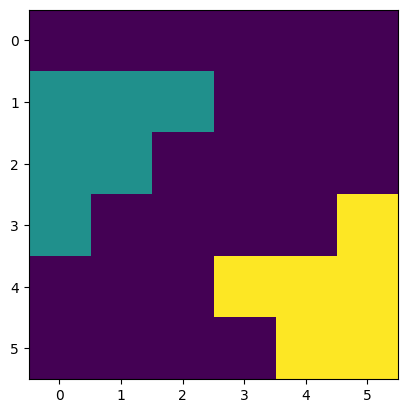

In [46]:
plt.imshow(image)

In [129]:
#compute XY points of masks
class_1 = np.array(np.where(image==1)).T
class_2 = np.array(np.where(image==2)).T

In [130]:
class_1

array([[1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [3, 0]], dtype=int64)

In [131]:
class_2

array([[3, 5],
       [4, 3],
       [4, 4],
       [4, 5],
       [5, 4],
       [5, 5]], dtype=int64)

In [132]:
distance.cdist(class_1, class_2)

array([[     5.3852,      4.2426,           5,       5.831,      5.6569,      6.4031],
       [     4.4721,      3.6056,      4.2426,           5,           5,      5.6569],
       [     3.6056,      3.1623,      3.6056,      4.2426,      4.4721,           5],
       [      5.099,      3.6056,      4.4721,      5.3852,           5,       5.831],
       [     4.1231,      2.8284,      3.6056,      4.4721,      4.2426,           5],
       [          5,      3.1623,      4.1231,       5.099,      4.4721,      5.3852]])

In [133]:
distance.cdist(class_1, class_2).min()

2.8284271247461903

In [134]:
i, j = np.where( distance.cdist(class_1, class_2) == distance.cdist(class_1, class_2).min())

In [135]:
i[0]

4

In [136]:
j[0]

1

In [4]:
def compute_mask_dist(mask1, mask2):
   #compute the distance between two masks of classes 1 and 2
     
   i, j = np.where(distance.cdist(mask1, mask2) == distance.cdist(mask1, mask2).min())
   
   #compute nearest points between masks as (y,x)
   point1 = mask1[i[0],:][::-1] #swap point coordinates to be (x,y)
   point2 = mask2[j[0],:][::-1] #swap point coordinates to be (x,y)
   
   
   
   return distance.cdist(mask1, mask2).min(), point1, point2
   

### Training yolov8 segmentation model

In [5]:
#load pretrained model
seg_model = YOLO('yolov8n-seg.pt')

In [94]:
seg_model.train(data='segmentation_data.yaml', epochs=100, imgsz=640, batch=16, pretrained=True, mosaic=0.0)

New https://pypi.org/project/ultralytics/8.0.203 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=segmentation_data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False,

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F52A01ACA0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [95]:
results = pd.read_csv("runs/segment/train5/results.csv")

In [96]:
stripped_columns = [column.strip() for column in results.columns]
results.columns = stripped_columns

In [97]:
results.columns

Index(['epoch', 'train/box_loss', 'train/seg_loss', 'train/cls_loss',
       'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)',
       'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)',
       'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)',
       'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

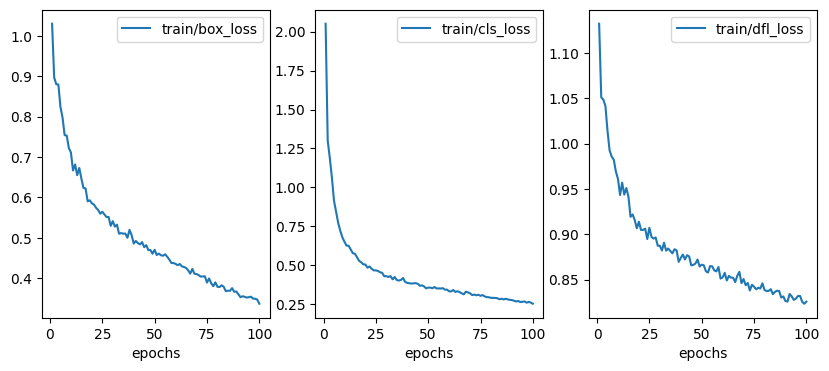

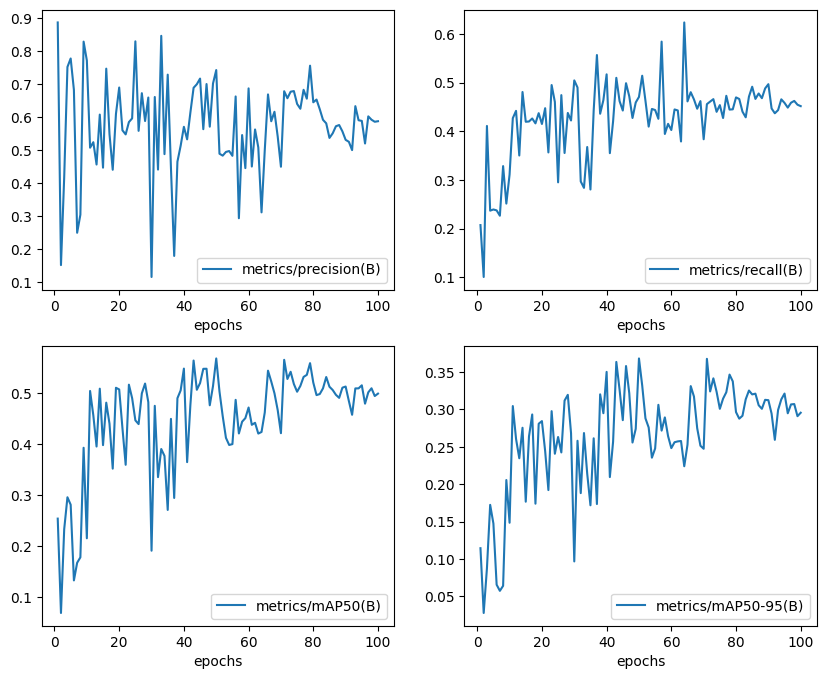

In [98]:
columns = ['train/box_loss','train/cls_loss', 'train/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)',
           'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
for i, column in enumerate(columns[:3]):
    axes[i].plot(results['epoch'], results[column], label=column)
    axes[i].set_xlabel("epochs")
    axes[i].legend(loc="upper right")   
plt.tight_layout
plt.savefig('figures/losses.png')
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i, column in enumerate(columns[3:]):
    axes[i//2, i%2].plot(results['epoch'], results[column], label=column)
    axes[i//2, i%2].set_xlabel("epochs")
    axes[i//2, i%2].legend(loc="lower right")   
plt.tight_layout
plt.savefig('figures/metrics.png')
plt.show()


In [6]:
seg_model = YOLO('runs/segment/train5/weights/best.pt')  # load a custom model

# Validate the model
metrics = seg_model.val(data="segmentation_data.yaml")

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning C:\Projects\Distance_project\segmentation_data\valid\labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]
                   all        101        696      0.742       0.47      0.569      0.368      0.736      0.467      0.568      0.367
             machinery        101        207       0.84      0.647      0.706      0.538       0.84      0.647      0.707      0.559
                person        101        489      0.645      0.293      0.432      0.199      0.631      0.287      0.428      0.175
Speed: 0.8ms preprocess, 75.9ms inference, 0.0ms loss, 0.1ms postproc

In [7]:
#function that takes prediction and class number and return indices of the mask of that class
def get_mask_indices(cls, pred):
    classes = pred[0].boxes.cls
    #extract necessary indices for the class
    indices = np.where(classes == cls)[0]
    #print(indices)
    res_mask = np.zeros(shape=pred[0].masks[0].shape, dtype=np.float32)
    #unite masks from several predictions
    for i in indices:
        res_mask=cv2.bitwise_or(res_mask, pred[0].masks[i].data.numpy())
    
    res_mask = np.squeeze(res_mask)   
    #plt.imshow(res_mask*255)
    
    #return indices where mask == 1
    return np.array(np.where(res_mask==1)).T   
    
        

In [8]:
def get_mask(pred):
    classes = pred[0].boxes.cls
    res_mask = np.zeros(shape=pred[0].masks[0].shape, dtype=np.float32)
    #draw all masks on the image
    for i in range(len(classes)):
        res_mask=cv2.bitwise_or(res_mask, pred[0].masks[i].data.numpy())
    
    res_mask = np.squeeze(res_mask)   
    #plt.imshow(res_mask*255)
    
    return res_mask   
    

In [9]:
def create_overlay(image, mask):
    """
    image: H*W*3 numpy array
    mask: H*W numpy array
    If dimensions do not match, the mask is upsampled to match that of the image

    Returns a H*W*3 numpy array
    """
    h, w = mask.shape[:2]
    
    image = cv2.resize(image, dsize=(w,h), interpolation=cv2.INTER_CUBIC)
    
    # h, w = image.shape[:2]
    # mask = cv2.resize(mask, dsize=(w,h), interpolation=cv2.INTER_CUBIC)

    # color options: https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html
    #mask_color = cv2.applyColorMap(mask, cv2.COLORMAP_HOT).astype(np.float32)
    mask = mask[:, :, None] # create trailing dimension for broadcasting
    mask = mask.astype(np.float32)*255

    # different other options that you can use to merge image/mask
    #overlay = (image*(1-mask)+mask_color*mask).astype(np.uint8)
    overlay = (image*0.5 + mask*0.5).astype(np.uint8)
    
    # overlay = (image + mask_color).clip(0,255).astype(np.uint8)

    return overlay

In [76]:
# Predict with the model
pred = seg_model.predict("frames/industry1_frame38.jpg")  # predict on an image


image 1/1 c:\Projects\Distance_project\frames\industry1_frame38.jpg: 384x640 1 machinery, 2 persons, 98.9ms
Speed: 2.2ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


In [36]:
pred[0].boxes.cls

tensor([1., 1., 0.])

In [69]:
pred[0].masks[0].data

tensor(1.)

In [49]:
machinery_ind = get_mask_indices(0, pred)

In [43]:
machinery_ind

array([[ 16, 114],
       [ 16, 115],
       [ 16, 116],
       ...,
       [366, 495],
       [366, 496],
       [366, 497]], dtype=int64)

In [50]:
classes = pred[0].boxes.cls
    #extract necessary indices for the class
indices = np.where(classes == 0)[0]
    #print(indices)
res_mask = np.zeros(shape=pred[0].masks[0].shape, dtype=np.float32)
    #unite masks from several predictions
for i in indices:
    res_mask=cv2.bitwise_or(res_mask, pred[0].masks[i].data.numpy())
    
res_mask = np.squeeze(res_mask) 

In [51]:
res_mask = cv2.resize(res_mask, dsize=image.shape[:2][::-1])

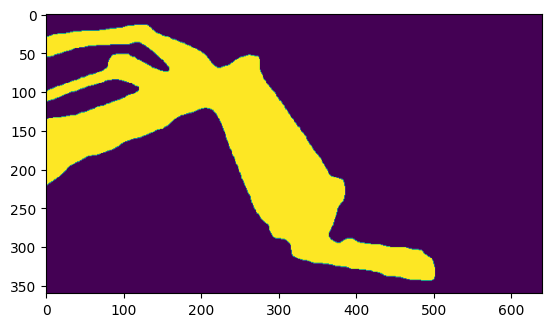

In [52]:
plt.imshow(res_mask*255)

In [77]:
result = get_mask(pred)

In [55]:
result = cv2.resize(result, dsize = image.shape[:2][::-1])

In [83]:
image = cv2.imread("frames/industry1_frame38.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
#image = cv2.resize(image, (384, 640))

In [40]:
image.shape

(360, 640, 3)

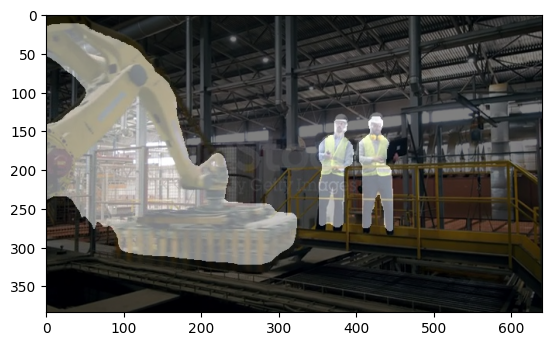

In [85]:
overlay = create_overlay(image_rgb, result)
plt.imshow( overlay)

In [86]:
mask = get_mask(pred)
mask_machinery = get_mask_indices(0, pred)
mask_person = get_mask_indices(1, pred)

In [81]:
mask_dist, point1, point2 = compute_mask_dist(mask_machinery, mask_person)

In [21]:
mask_dist

0.0

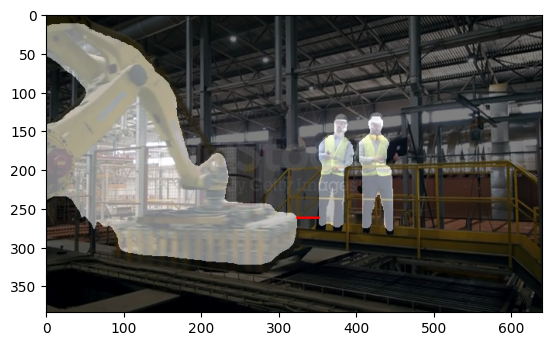

In [87]:
cv2.line(overlay, point1, point2, color = (255, 0, 0), thickness=2)
plt.imshow(overlay)

In [142]:
mask_machinery

array([[ 17,   0],
       [ 17,   1],
       [ 17,   2],
       ...,
       [313, 189],
       [314, 169],
       [314, 170]], dtype=int64)

In [143]:
point2

array([348, 264], dtype=int64)

In [144]:
mask_person

array([[140, 373],
       [140, 374],
       [140, 375],
       ...,
       [286, 432],
       [286, 433],
       [286, 434]], dtype=int64)

In [156]:
if point1[::-1] in mask_machinery:
    print("yes")

yes


In [158]:
if point2[::-1] in mask_person:
    print("yes")

yes


In [12]:
seg_model = YOLO('runs/segment/train5/weights/best.pt')

In [90]:
cap = cv2.VideoCapture("videos/industry1.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


cap_writer = cv2.VideoWriter('result_segment_industry1.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))

success, frame = cap.read()
frame_num=0
total_fps=0

while success:
    
    
    pred = seg_model.predict(frame)
    mask = get_mask(pred)
    h, w = mask.shape[:2]
    
    frame = cv2.resize(frame, dsize=(w,h), interpolation=cv2.INTER_CUBIC)
    
    mask_machinery = get_mask_indices(0, pred)
    mask_person = get_mask_indices(1, pred)
    if len(mask_machinery) != 0 and len(mask_person)!=0:
        mask_dist, point1, point2 = compute_mask_dist(mask_machinery, mask_person)
        if mask_dist < 20:
            cv2.line(frame, point1, point2, color = (0, 0, 255), thickness=2) 
            cv2.putText(frame, "ALARM!", (20, 50), cv2.FONT_HERSHEY_SIMPLEX , fontScale = 1, color=(0, 0, 255), thickness=5) 
    
    frame = create_overlay(frame, mask)
    cv2.rectangle(frame, (frame_width-100, 20), (frame_width-10, 60), (0,0,0), -1)
    fps = get_fps(frame_num)
    cv2.putText(frame, "%.2f FPS" % fps, (frame_width-100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX , fontScale = 0.5, color=(255, 255, 255), thickness=1) 
    total_fps+=fps
                
                    
    #resize frame for videowriter
    frame = cv2.resize(frame, dsize=(frame_width, frame_height), interpolation=cv2.INTER_CUBIC) 
    cap_writer.write(frame)      
    cv2.imshow('YOLO V8 Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    success, frame = cap.read()
    frame_num+=1
    

cap.release()

cv2.destroyAllWindows()

0: 384x640 2 persons, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 83.0ms
Speed: 2.3ms preprocess, 83.0ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 77.4ms
Speed: 1.5ms preprocess, 77.4ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 63.0ms
Speed: 0.0ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape

In [91]:
#average FPS
total_fps/(frame_num+1)

0.44227202990905135

### Convert to ONNX model

In [70]:
seg_model = YOLO('runs/segment/train5/weights/best.pt')
seg_model.export(format="onnx",imgsz=[640,640], opset=12)

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from 'runs\segment\train5\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 38, 8400), (1, 32, 160, 160)) (6.4 MB)

ONNX: starting export with onnx 1.14.1 opset 12...
ONNX: export success  1.0s, saved as 'runs\segment\train5\weights\best.onnx' (12.6 MB)

Export complete (3.0s)
Results saved to C:\Projects\Distance_project\runs\segment\train5\weights
Predict:         yolo predict task=segment model=runs\segment\train5\weights\best.onnx imgsz=640  
Validate:        yolo val task=segment model=runs\segment\train5\weights\best.onnx imgsz=640 data=segmentation_data.yaml  
Visualize:       https://netron.app


'runs\\segment\\train5\\weights\\best.onnx'

### Segment anything model

In [6]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# this is classical PyTorch mode
sam = sam_model_registry["vit_b"](checkpoint="SAM_checkpoints/sam_vit_b.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

# read in some image file ...
image_bgr = cv2.imread("train_frames/industry1_frame34.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#mask = mask_generator.generate(image_rgb)

cpu


In [34]:
mask

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 922,
  'bbox': [158, 76, 34, 33],
  'predicted_iou': 0.997586727142334,
  'point_coords': [[190.0, 84.375]],
  'stability_score': 0.9806867241859436,
  'crop_box': [0, 0, 640, 360]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ..., False,  True,  True],
         [False, False, False, ..., False, False, False]]),
  'area': 1801,
  'bbox': [630, 123, 9, 235],
 

In [36]:
len(mask)

140

In [37]:
for seg in mask:
    print(seg['segmentation'].shape)

(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)
(360, 640)

In [39]:
def build_totalmask(pred):
    """Builds a total mask from a list of segmentations
    ARGS:
        pred (list): list of dicts with keys 'segmentation' and others
    RETURNS:
        total_mask (np.ndarray): total mask

    """

    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    for seg in pred:
        total_mask += seg['segmentation']
    # use cv2 to make image black and white
    _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    return total_mask

tmask = build_totalmask(mask)

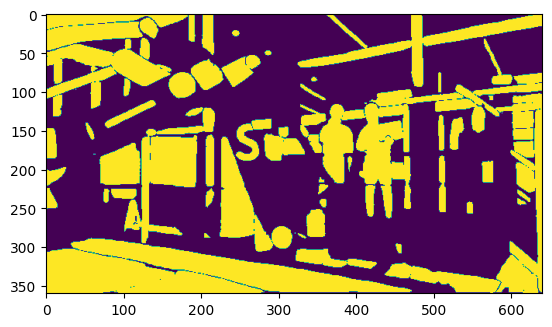

In [40]:
plt.imshow(tmask)

In [9]:
mask_predictor=SamPredictor(sam)

In [11]:
x, y, width, height = 0.23453125, 0.4335, 0.469046875, 0.8649444444444444

In [12]:
h, w = image_rgb.shape[:2]

In [13]:
x1 = int(x*w)-int(width*w/2)
y1 = int(y*h)-int(height*h/2)
x2 = x1 + int(width*w)
y2 = y1 + int(height*h)

bbox = np.array([x1, y1, x2, y2])

In [109]:
bbox

array([  0,   1, 300, 312])

In [54]:
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=bbox,
    multimask_output=False
)

In [ ]:
def unite_masks()

In [57]:
def convert_mask(mask):
    mask = mask.astype("uint8")
    mask_indices = np.where(masks==1)
    mask_indices = np.array(mask_indices[1:]).T
    return mask_indices

In [59]:
convert_mask(masks)

array([[  0, 295],
       [  0, 296],
       [  0, 297],
       ...,
       [165, 317],
       [165, 318],
       [165, 319]], dtype=int64)

: 

In [40]:
masks = masks.astype("uint8")

In [41]:
masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [42]:
mask_indices = np.where(masks==1)

In [43]:
mask_indices

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([  0,   0,   0, ..., 303, 303, 303], dtype=int64),
 array([ 11,  12,  13, ..., 251, 252, 253], dtype=int64))

In [44]:
np.array(mask_indices[1:]).T

array([[  0,  11],
       [  0,  12],
       [  0,  13],
       ...,
       [303, 251],
       [303, 252],
       [303, 253]], dtype=int64)

In [45]:
masks.shape

(1, 360, 640)

In [46]:
masks=masks.transpose(1,2,0)

In [47]:
masks.shape

(360, 640, 1)

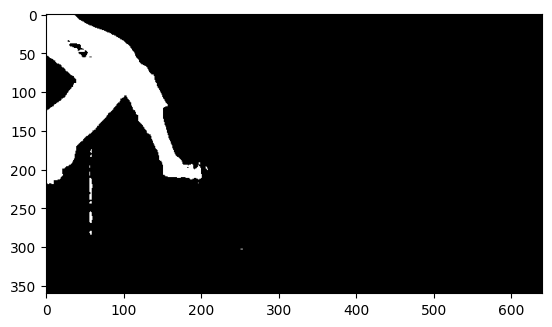

In [48]:
# _, total_mask = cv2.threshold(masks.transpose(1,2,0), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(masks[:,:,0]*255, cmap="gray")